In [1]:
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Input, GlobalAveragePooling2D, Dense, Concatenate, Conv2D, MaxPooling2D, Lambda, Flatten
from tensorflow.keras.models import Model, Sequential
import tensorflow as tf
import nltk
from IPython.display import clear_output
import time
import tensorflow_hub as hub
from tqdm import tqdm
import cv2
nltk.download('words')
from nltk.corpus import words
from keras.initializers import he_normal
from keras.constraints import max_norm
from keras.regularizers import l1
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers
import pandas as pd
import os
import glob
import numpy as np
from PIL import Image
import random
from random import randint
import math
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Nadam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-05-10 06:24:40.949551: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 06:24:40.949691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 06:24:41.088124: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
file_path = '/kaggle/input/lung-disease-clinical-texts-and-image-processed/lung_disease_clinical_texts_processed.csv'
data_frame = pd.read_csv(file_path)

data_frame.head()

clinical_text  \
0  I have a chronic cough that is. It ' s very ha...   
1  'It a headache and a throat. I got and chills....   
2  I have been coughing up blood for a while now....   
3  I had a sharp in chest and arm made me gasp. I...   
4  I don ' t know what ' s wrong with me. I have ...   

                          disease  
0  Obstructive Pulmonary Diseases  
1  Obstructive Pulmonary Diseases  
2  Obstructive Pulmonary Diseases  
3  Obstructive Pulmonary Diseases  
4  Obstructive Pulmonary Diseases

In [3]:
unique_diseases = data_frame['disease'].unique()
print(unique_diseases)

['Obstructive Pulmonary Diseases' 'Higher Density' 'Lower Density'
 'Chest Changes' 'Encapsulated Lesions' 'Degenerative Infectious Diseases'
 'Normal' 'Mediastinal Changes']


In [4]:
# Rename the 'disease' column to 'label' in the data_frame DataFrame
data_frame.rename(columns={'disease': 'label'}, inplace=True)

# Display the DataFrame to verify the column name change
data_frame.head()

clinical_text  \
0  I have a chronic cough that is. It ' s very ha...   
1  'It a headache and a throat. I got and chills....   
2  I have been coughing up blood for a while now....   
3  I had a sharp in chest and arm made me gasp. I...   
4  I don ' t know what ' s wrong with me. I have ...   

                            label  
0  Obstructive Pulmonary Diseases  
1  Obstructive Pulmonary Diseases  
2  Obstructive Pulmonary Diseases  
3  Obstructive Pulmonary Diseases  
4  Obstructive Pulmonary Diseases

In [5]:
print("Number of unique values in 'clinical_text' column:", data_frame['clinical_text'].nunique())

Number of unique values in 'clinical_text' column: 8000


In [6]:
def create_augmented_df(path, target_shape=(256, 256)):
    classes = os.listdir(path)  # Get the list of class directories
    data = []  # List to store image data and class labels
    
    # Read and store each image and its class
    for cls in classes:
        for file in glob.glob(f"{path}/{cls}/*"):
            if file.endswith(('png', 'jpeg', 'jpg')):
                # Open the image file
                image = Image.open(file)
                
                # Resize the image to the target shape
                resized_image = image.resize(target_shape)
                
                # Append the resized image and its class to the list
                data.append((resized_image, cls))
                
                # Data augmentation - horizontal flip
                flipped_image = resized_image.transpose(Image.FLIP_LEFT_RIGHT)
                data.append((flipped_image, cls))  # Append the augmented image and its class
    
    # Create a DataFrame
    df = pd.DataFrame(data, columns=['image', 'label'])
    
    return df

In [7]:
image_data = create_augmented_df('/kaggle/input/x-ray-lung-diseases-images-9-classes')

In [8]:
image_data.head()

image  \
0  <PIL.Image.Image image mode=RGB size=256x256 a...   
1  <PIL.Image.Image image mode=RGB size=256x256 a...   
2  <PIL.Image.Image image mode=RGB size=256x256 a...   
3  <PIL.Image.Image image mode=RGB size=256x256 a...   
4  <PIL.Image.Image image mode=RGB size=256x256 a...   

                                               label  
0  04 Doenças Pulmonares Obstrutivas (Enfisema, B...  
1  04 Doenças Pulmonares Obstrutivas (Enfisema, B...  
2  04 Doenças Pulmonares Obstrutivas (Enfisema, B...  
3  04 Doenças Pulmonares Obstrutivas (Enfisema, B...  
4  04 Doenças Pulmonares Obstrutivas (Enfisema, B...

In [9]:
class_counts = image_data['label'].value_counts()
print(class_counts)

label
00 Anatomia Normal                                                                           2680
01 Processos Inflamatórios Pulmonares (Pneumonia)                                            2120
02 Maior Densidade (Derrame Pleural, Consolidação Atelectasica, Hidrotorax, Empiema)         1342
06 Lesões Encapsuladas (Abscessos, Nódulos, Cistos, Massas Tumorais, Metastases)             1316
04 Doenças Pulmonares Obstrutivas (Enfisema, Broncopneumonia, Bronquiectasia, Embolia)       1274
03 Menor Densidade (Pneumotorax, Pneumomediastino, Pneumoperitonio)                          1258
07 Alterações de Mediastino (Pericardite, Malformações Arteriovenosas, Linfonodomegalias)    1192
05 Doenças Infecciosas Degenerativas (Tuberculose, Sarcoidose, Proteinose, Fibrose)          1160
08 Alterações do Tórax (Atelectasias, Malformações, Agenesia, Hipoplasias)                   1088
Name: count, dtype: int64


In [10]:
# Define a dictionary to map disease names from different languages to English short names
disease_mapping = {
    "00 Anatomia Normal": "Normal",
    "01 Processos Inflamatórios Pulmonares (Pneumonia)": "Inflammatory Processes",
    "02 Maior Densidade (Derrame Pleural, Consolidação Atelectasica, Hidrotorax, Empiema)": "Higher Density",
    "06 Lesões Encapsuladas (Abscessos, Nódulos, Cistos, Massas Tumorais, Metastases)": "Encapsulated Lesions",
    "04 Doenças Pulmonares Obstrutivas (Enfisema, Broncopneumonia, Bronquiectasia, Embolia)": "Obstructive Pulmonary Diseases",
    "03 Menor Densidade (Pneumotorax, Pneumomediastino, Pneumoperitonio)": "Lower Density",
    "07 Alterações de Mediastino (Pericardite, Malformações Arteriovenosas, Linfonodomegalias)": "Mediastinal Changes",
    "05 Doenças Infecciosas Degenerativas (Tuberculose, Sarcoidose, Proteinose, Fibrose)": "Degenerative Infectious Diseases",
    "08 Alterações do Tórax (Atelectasias, Malformações, Agenesia, Hipoplasias)": "Chest Changes"
}

# Replace the values in the 'Class' column of df with their corresponding English short names
image_data['label'] = image_data['label'].replace(disease_mapping)

In [11]:
class_counts = image_data['label'].value_counts()
print(class_counts)

label
Normal                              2680
Inflammatory Processes              2120
Higher Density                      1342
Encapsulated Lesions                1316
Obstructive Pulmonary Diseases      1274
Lower Density                       1258
Mediastinal Changes                 1192
Degenerative Infectious Diseases    1160
Chest Changes                       1088
Name: count, dtype: int64


In [12]:
image_data.shape

(13430, 2)

In [13]:
image_data.head()

image  \
0  <PIL.Image.Image image mode=RGB size=256x256 a...   
1  <PIL.Image.Image image mode=RGB size=256x256 a...   
2  <PIL.Image.Image image mode=RGB size=256x256 a...   
3  <PIL.Image.Image image mode=RGB size=256x256 a...   
4  <PIL.Image.Image image mode=RGB size=256x256 a...   

                            label  
0  Obstructive Pulmonary Diseases  
1  Obstructive Pulmonary Diseases  
2  Obstructive Pulmonary Diseases  
3  Obstructive Pulmonary Diseases  
4  Obstructive Pulmonary Diseases

In [14]:
def balance_data(image_data):
    # Remove rows with 'Inflammatory Processes' label
    image_data = image_data[image_data['label'] != 'Inflammatory Processes']
    
    # Sample 1000 rows for each label
    labels = image_data['label'].unique()
    sampled_data = pd.DataFrame()
    for label in labels:
        label_data = image_data[image_data['label'] == label]
        if len(label_data) > 1000:
            label_data = label_data.sample(n=1000, random_state=42)
        sampled_data = pd.concat([sampled_data, label_data])
    
    return sampled_data

In [15]:
image_data = balance_data(image_data)
class_counts = image_data['label'].value_counts()
print(class_counts)

label
Obstructive Pulmonary Diseases      1000
Higher Density                      1000
Lower Density                       1000
Chest Changes                       1000
Encapsulated Lesions                1000
Degenerative Infectious Diseases    1000
Normal                              1000
Mediastinal Changes                 1000
Name: count, dtype: int64


In [16]:
image_data.reset_index(drop=True, inplace=True)
image_data.head()

image  \
0  <PIL.Image.Image image mode=RGB size=256x256 a...   
1  <PIL.Image.Image image mode=L size=256x256 at ...   
2  <PIL.Image.Image image mode=RGB size=256x256 a...   
3  <PIL.Image.Image image mode=RGB size=256x256 a...   
4  <PIL.Image.Image image mode=L size=256x256 at ...   

                            label  
0  Obstructive Pulmonary Diseases  
1  Obstructive Pulmonary Diseases  
2  Obstructive Pulmonary Diseases  
3  Obstructive Pulmonary Diseases  
4  Obstructive Pulmonary Diseases

In [17]:
print(image_data.loc[0, 'image'])
print(image_data.loc[1, 'image'])
print(data_frame.loc[0, 'clinical_text'])
print(data_frame.loc[1, 'clinical_text'])

<PIL.Image.Image image mode=RGB size=256x256 at 0x79D5A7BF46A0>
<PIL.Image.Image image mode=L size=256x256 at 0x79D5A7A30190>
I have a chronic cough that is. It ' s very hard to breathe and I a lot of mucus and blood my. It ' s very and it makes me spit. I also have a lot of chest pain and crackling. I feel very tired and I have lost lot. My nails are also abnormal, they are thick and curved.
'It a headache and a throat. I got and chills. I had trouble breathing and I felt dizzy. My was and I was coughing up mucus. I felt confused and.'


In [18]:
# Sort the 'label' column of data_frame in alphabetical order and reset index
data_frame = data_frame.sort_values(by='label').reset_index(drop=True)

# Sort the 'label' column of image_data in alphabetical order and reset index
image_data = image_data.sort_values(by='label').reset_index(drop=True)

# Display the sorted DataFrames
print("Sorted data_frame:")
print(data_frame.head())

print("\nSorted image_data:")
print(image_data.head())

Sorted data_frame:
                                       clinical_text          label
0  I feel like less air in my lungs than normal. ...  Chest Changes
1  I ' ve been coughing a lot thick. I have fever...  Chest Changes
2  'My, harp, and my voice, shall be exceeding lo...  Chest Changes
3  'I was feeling weird in my body, allergic to m...  Chest Changes
4  I have been suffering from frequent lung infec...  Chest Changes

Sorted image_data:
                                               image          label
0  <PIL.Image.Image image mode=RGB size=256x256 a...  Chest Changes
1  <PIL.Image.Image image mode=RGB size=256x256 a...  Chest Changes
2  <PIL.Image.Image image mode=L size=256x256 at ...  Chest Changes
3  <PIL.Image.Image image mode=RGB size=256x256 a...  Chest Changes
4  <PIL.Image.Image image mode=RGB size=256x256 a...  Chest Changes


In [19]:
print(data_frame.shape)
print(image_data.shape)

(8000, 2)
(8000, 2)


In [20]:
print(image_data.loc[0, 'image'])
print(image_data.loc[1, 'image'])
print(data_frame.loc[0, 'clinical_text'])
print(data_frame.loc[1, 'clinical_text'])

<PIL.Image.Image image mode=RGB size=256x256 at 0x79D5A78BDD20>
<PIL.Image.Image image mode=RGB size=256x256 at 0x79D5A78FA230>
I feel like less air in my lungs than normal. I temperature and chest pain. I cough phlegm and hear some sounds when I breathe. My breathing is shallow fast. My chest ' t move when I breathe.
I ' ve been coughing a lot thick. I have fever and. My fast and shallow. I hear some wheezing sounds in my chest. My doesn ' t move when I breathe.


In [21]:
def compute_label_similarity(data_frame, image_data):
    # Assuming 'data_frame' and 'image_data' are your datasets
    # Replace these lines with loading your actual datasets
    
    # Example data for demonstration
    data_frame = pd.DataFrame(data_frame)
    image_data = pd.DataFrame(image_data)
    
    # Check if 'label' column exists in both datasets
    if 'label' not in data_frame.columns or 'label' not in image_data.columns:
        raise ValueError("Both datasets must contain a column named 'label'")
    
    # Count the number of matching labels
    matching_labels = sum(data_frame['label'] == image_data['label'])
    
    # Calculate the percentage of matching labels
    total_labels = len(data_frame)
    similarity_percentage = (matching_labels / total_labels) * 100
    
    return similarity_percentage

In [22]:
try:
    percentage_similarity = compute_label_similarity(data_frame, image_data)
    print("Percentage of label similarity:", percentage_similarity)
except ValueError as e:
    print(e)

Percentage of label similarity: 100.0


In [23]:
print("Data Frame Label Counts:", data_frame['label'].value_counts())
print("Image Data Label Counts:", image_data['label'].value_counts())

Data Frame Label Counts: label
Chest Changes                       1000
Degenerative Infectious Diseases    1000
Encapsulated Lesions                1000
Higher Density                      1000
Lower Density                       1000
Mediastinal Changes                 1000
Normal                              1000
Obstructive Pulmonary Diseases      1000
Name: count, dtype: int64
Image Data Label Counts: label
Chest Changes                       1000
Degenerative Infectious Diseases    1000
Encapsulated Lesions                1000
Higher Density                      1000
Lower Density                       1000
Mediastinal Changes                 1000
Normal                              1000
Obstructive Pulmonary Diseases      1000
Name: count, dtype: int64


In [24]:
# Remove the common column 'label' from 'image_data'
data_frame = data_frame.drop(columns=['label'])
# Concatenate the datasets column-wise
merged_data = pd.concat([data_frame, image_data], axis=1)

merged_data.head()

clinical_text  \
0  I feel like less air in my lungs than normal. ...   
1  I ' ve been coughing a lot thick. I have fever...   
2  'My, harp, and my voice, shall be exceeding lo...   
3  'I was feeling weird in my body, allergic to m...   
4  I have been suffering from frequent lung infec...   

                                               image          label  
0  <PIL.Image.Image image mode=RGB size=256x256 a...  Chest Changes  
1  <PIL.Image.Image image mode=RGB size=256x256 a...  Chest Changes  
2  <PIL.Image.Image image mode=L size=256x256 at ...  Chest Changes  
3  <PIL.Image.Image image mode=RGB size=256x256 a...  Chest Changes  
4  <PIL.Image.Image image mode=RGB size=256x256 a...  Chest Changes

In [25]:
merged_data.shape

(8000, 3)

In [26]:
del image_data
del data_frame
del file_path
del unique_diseases

In [27]:
merged_data.sample(frac=1, random_state=4200).reset_index(drop=True)

clinical_text  \
0     I have a horrible cough that has been going on...   
1     I ' m suffering a lot of pain my abdomen. ' s ...   
2     I have fever, I ' m shaking a lot. I cough, I ...   
3     'I coughed a lot and produced a thick mucus. I...   
4     I don ' t feel like eating anything, and I ' m...   
...                                                 ...   
7995  I ' m, and I a in my. I also have a fever, a c...   
7996  I have nodules in my and I have symptoms that ...   
7997  'I had a fever, I sweated lot. I coughed, I co...   
7998  'Have a common cough that is very annoying. It...   
7999  I ' ve got a fever and I ' m sweating a lot. I...   

                                                  image  \
0     <PIL.Image.Image image mode=RGB size=256x256 a...   
1     <PIL.Image.Image image mode=L size=256x256 at ...   
2     <PIL.Image.Image image mode=RGB size=256x256 a...   
3     <PIL.Image.Image image mode=L size=256x256 at ...   
4     <PIL.Image.Image image mode=RGB size=256x256 a...   
...                                                 ...   
7995  <PIL.Image.Image image mode=RGB size=256x256 a...   
7996  <PIL.Image.Image image mode=L size=256x256 at ...   
7997  <PIL.Image.Image image mode=L size=256x256 at ...   
7998  <PIL.Image.Image image mode=L size=256x256 at ...   
7999  <PIL.Image.Image image mode=L size=256x256 at ...   

                                 label  
0     Degenerative Infectious Diseases  
1                        Lower Density  
2       Obstructive Pulmonary Diseases  
3                        Chest Changes  
4     Degenerative Infectious Diseases  
...                                ...  
7995                    Higher Density  
7996              Encapsulated Lesions  
7997    Obstructive Pulmonary Diseases  
7998    Obstructive Pulmonary Diseases  
7999    Obstructive Pulmonary Diseases  

[8000 rows x 3 columns]

In [28]:
merged_data_array = merged_data.to_numpy()  # Convert DataFrame to NumPy array
np.random.shuffle(merged_data_array)  # Shuffle the array in-place
merged_data = pd.DataFrame(merged_data_array, columns=merged_data.columns) 
merged_data

clinical_text  \
0     I can ' t breathe, I ' m suffocating, chest ti...   
1     'I remember, am faint because of grief. have h...   
2     I've had a cough for a long time, and it's not...   
3     'And when I saw that there was no meat in the ...   
4     'I a puncture pain chest, under cane, that hap...   
...                                                 ...   
7995  I ' have breathing or pains. I feel better eve...   
7996  I have cough that lasts for long time. It ' s ...   
7997  I feel like I can ' t get enough. also have a ...   
7998  I've had a cough for a long time, and it's not...   
7999  First it dry, then I felt wound my chest. I co...   

                                                  image                 label  
0     <PIL.Image.Image image mode=RGB size=256x256 a...        Higher Density  
1     <PIL.Image.Image image mode=L size=256x256 at ...         Lower Density  
2     <PIL.Image.Image image mode=L size=256x256 at ...  Encapsulated Lesions  
3     <PIL.Image.Image image mode=L size=256x256 at ...                Normal  
4     <PIL.Image.Image image mode=L size=256x256 at ...         Lower Density  
...                                                 ...                   ...  
7995  <PIL.Image.Image image mode=L size=256x256 at ...                Normal  
7996  <PIL.Image.Image image mode=L size=256x256 at ...  Encapsulated Lesions  
7997  <PIL.Image.Image image mode=RGB size=256x256 a...         Chest Changes  
7998  <PIL.Image.Image image mode=L size=256x256 at ...  Encapsulated Lesions  
7999  <PIL.Image.Image image mode=RGB size=256x256 a...         Lower Density  

[8000 rows x 3 columns]

In [29]:
print("Number of unique values in 'clinical_text' column:", merged_data['clinical_text'].nunique())

Number of unique values in 'clinical_text' column: 8000


In [30]:
print(merged_data.loc[0, 'image'])
print(merged_data.loc[1, 'image'])
print(merged_data.loc[0, 'clinical_text'])
print(merged_data.loc[1, 'clinical_text'])

<PIL.Image.Image image mode=RGB size=256x256 at 0x79D5A792AA70>
<PIL.Image.Image image mode=L size=256x256 at 0x79D5A79D4E20>
I can ' t breathe, I ' m suffocating, chest tight, I ' coughing, ' m coughing, ', I ' m coughing. I ' about what ' s to me.
'I remember, am faint because of grief. have healed me, old man. I am in my heart, I am weak, and faint; am, and Make my.'


In [31]:
word_list = words.words()

# Function to add random words to a sentence
def add_random_words(sentence):
    words = sentence.split()
    num_words_to_add = random.randint(1, 5)  # Randomly choose the number of words to add
    for _ in range(num_words_to_add):
        random_word = random.choice(word_list)  # Select a random word from the library
        position = random.randint(0, len(words))  # Randomly choose a position to insert the word
        words.insert(position, random_word)
    return ' '.join(words)

# Function to rotate image
def rotate_image(image):
    return image.rotate(randint(1, 360))

In [32]:
multiplier = 3

In [33]:
# Augment text data
augmented_text_data = []
for index, row in merged_data.iterrows():
    original_sentence = row['clinical_text']
    original_label = row['label']
    for _ in range(multiplier):  # Create four variations for each original sentence
        new_sentence = add_random_words(original_sentence)
        augmented_text_data.append({'clinical_text': new_sentence, 'label': original_label})

In [34]:
# Augment image data
augmented_image_data = []
for index, row in merged_data.iterrows():
    original_image = row['image']
    original_label = row['label']
    for _ in range(multiplier):  # Create four variations for each original image
        rotated_image = rotate_image(original_image)
        augmented_image_data.append({'image': rotated_image, 'label': original_label})

In [35]:
# Convert augmented data to DataFrame
augmented_text_df = pd.DataFrame(augmented_text_data)
augmented_image_df = pd.DataFrame(augmented_image_data)

In [36]:
percentage_similarity = compute_label_similarity(augmented_text_df, augmented_image_df)
print("Percentage of label similarity:", percentage_similarity)

Percentage of label similarity: 100.0


In [37]:
# Combine text and image dataframes
augmented_text_df = augmented_text_df.drop(columns=['label'])
augmented_merged_data = pd.concat([augmented_text_df, augmented_image_df], axis=1)

# Shuffle the augmented data
augmented_merged_data = augmented_merged_data.sample(frac=1, random_state=42).reset_index(drop=True)
augmented_merged_data

clinical_text  \
0      I unslurred trouble breathing because of the i...   
1      'I inaqueous have poured out my blood for the ...   
2      'I feeling and feeble for the past few days. a...   
3      'My intestines are deformed, which affects my ...   
4      ametabolic 'Got a cold recently. had a runny n...   
...                                                  ...   
23995  I have difficulty breathing. ' sympathicotrips...   
23996  I have been feeling very exhausted and weak fo...   
23997  'Have had a fever and night for a suber while....   
23998  'I feel bad. I have a lot of in my abdomen. It...   
23999  ' ve been very weak and tired for the few days...   

                                                   image  \
0      <PIL.Image.Image image mode=L size=256x256 at ...   
1      <PIL.Image.Image image mode=RGB size=256x256 a...   
2      <PIL.Image.Image image mode=L size=256x256 at ...   
3      <PIL.Image.Image image mode=RGB size=256x256 a...   
4      <PIL.Image.Image image mode=RGB size=256x256 a...   
...                                                  ...   
23995  <PIL.Image.Image image mode=L size=256x256 at ...   
23996  <PIL.Image.Image image mode=L size=256x256 at ...   
23997  <PIL.Image.Image image mode=L size=256x256 at ...   
23998  <PIL.Image.Image image mode=RGB size=256x256 a...   
23999  <PIL.Image.Image image mode=RGB size=256x256 a...   

                                label  
0                Encapsulated Lesions  
1                       Chest Changes  
2                Encapsulated Lesions  
3                       Chest Changes  
4                 Mediastinal Changes  
...                               ...  
23995            Encapsulated Lesions  
23996            Encapsulated Lesions  
23997             Mediastinal Changes  
23998                   Lower Density  
23999  Obstructive Pulmonary Diseases  

[24000 rows x 3 columns]

In [38]:
merged_data = augmented_merged_data
del augmented_merged_data

In [39]:
merged_data.head()

clinical_text  \
0  I unslurred trouble breathing because of the i...   
1  'I inaqueous have poured out my blood for the ...   
2  'I feeling and feeble for the past few days. a...   
3  'My intestines are deformed, which affects my ...   
4  ametabolic 'Got a cold recently. had a runny n...   

                                               image                 label  
0  <PIL.Image.Image image mode=L size=256x256 at ...  Encapsulated Lesions  
1  <PIL.Image.Image image mode=RGB size=256x256 a...         Chest Changes  
2  <PIL.Image.Image image mode=L size=256x256 at ...  Encapsulated Lesions  
3  <PIL.Image.Image image mode=RGB size=256x256 a...         Chest Changes  
4  <PIL.Image.Image image mode=RGB size=256x256 a...   Mediastinal Changes

In [40]:

def process_row(row, image_col, text_col, label_col, embed, model1):
    image = np.array(row[image_col].convert("L"))  # Convert PIL image to NumPy array
    
    image_resized = cv2.resize(image, (256, 256))
    text_vector = embed([row[text_col]])[0]
    normalized_vector = (text_vector - tf.reduce_min(text_vector)) / (tf.reduce_max(text_vector) - tf.reduce_min(text_vector))
    scaled_vector = 100 * normalized_vector
    
    # Disable TensorFlow and Keras logging
    tf.get_logger().setLevel('ERROR')
    model1._silent_mode = True
    
    start_time = time.time()
    modified_vector = model1.predict(scaled_vector[None, :])[0]
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    modified_matrix = tf.reshape(modified_vector, (32, 32))
    upscaled_image = cv2.resize(modified_matrix.numpy(), (256, 256), interpolation=cv2.INTER_NEAREST)
    upscaled_image = np.array(upscaled_image, dtype=np.float32)
    image_resized = np.array(image_resized, dtype=np.float32)
    
    alpha = 0.3  # Blend factor
    overlay = cv2.addWeighted(upscaled_image, alpha, image_resized, 1 - alpha, 0)
    
    # Convert to PIL grayscale image
    overlay_pil = Image.fromarray(overlay).convert("L")
    #print(overlay_pil)
    #print(row[label_col])
    
    return overlay_pil, row[label_col], elapsed_time

In [41]:
def simple_txt_img_preprocessor(merged_data, image_col, text_col, label_col):
    embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
    model1 = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(512,)),  # Input shape matches the USE output
        tf.keras.layers.Dense(1024, activation=tf.keras.layers.LeakyReLU(negative_slope=0.2)),  # Map to 1024 dimensions
    ])
    
    processed_data = []
    total_rows = len(merged_data)
    with tqdm(total=total_rows, desc="Processing Rows", leave=True) as pbar:
        for idx, row in merged_data.iterrows():
            overlay, label, elapsed_time = process_row(row, image_col, text_col, label_col, embed, model1)
            processed_data.append({'overlay': overlay, 'label': label})
            pbar.update(1)
            pbar.set_postfix({'Time per iteration': f'{elapsed_time:.2f} s'})
            clear_output(wait=True)
    
    processed_data_df = pd.DataFrame(processed_data)
    return processed_data_df

In [42]:
processed_data = simple_txt_img_preprocessor(merged_data, 'image', 'clinical_text', 'label')

Processing Rows: 100%|██████████| 24000/24000 [29:57<00:00, 13.35it/s, Time per iteration=0.06 s]


In [43]:
processed_data.head()

overlay                 label
0  <PIL.Image.Image image mode=L size=256x256 at ...  Encapsulated Lesions
1  <PIL.Image.Image image mode=L size=256x256 at ...         Chest Changes
2  <PIL.Image.Image image mode=L size=256x256 at ...  Encapsulated Lesions
3  <PIL.Image.Image image mode=L size=256x256 at ...         Chest Changes
4  <PIL.Image.Image image mode=L size=256x256 at ...   Mediastinal Changes

In [44]:
# Function to convert grayscale image to RGB
def convert_to_rgb(image):
    return image.convert("RGB")

# Apply the function to all images in the 'overlay' column
processed_data['overlay'] = processed_data['overlay'].apply(convert_to_rgb)

In [45]:
# Extract labels, texts, and images from merged_data
labels = []
images = []

for index, row in processed_data.iterrows():
    label = row['label']
    image = row['overlay']
    
    #numerical_label = label_mapping[label]
    
    labels.append(label)
    images.append(image)

In [46]:
# Convert labels to numpy array
labels = np.array(labels)

# Convert images to numpy arrays
image_arrays = []

for img in images:
    # Convert image to numpy array
    img_array = np.array(img)
    # Check if the image is grayscale
    if len(img_array.shape) == 2:
        img_gray = img_array  # Already grayscale, no need to convert
    else:
        # Convert RGB image to grayscale
        img_gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    # Resize
    img_resized = cv2.resize(img_gray, (256, 256))
    image_arrays.append(img_resized)

images = np.array(image_arrays)

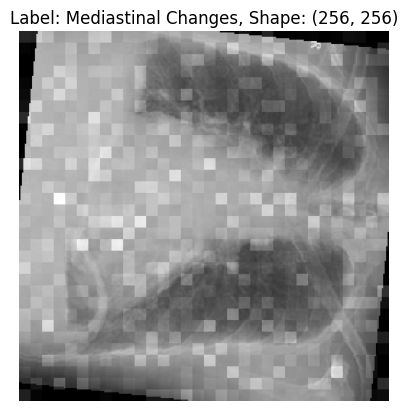

In [47]:
# Randomly select an index
random_index = np.random.randint(0, len(processed_data))

# Select the image and its corresponding label
random_image = images[random_index]
random_label = labels[random_index]

# Plot the image
plt.imshow(random_image, cmap='gray')  # Assuming the images are grayscale
plt.title(f'Label: {random_label}, Shape: {random_image.shape}')
plt.axis('off')
plt.show()

In [48]:
del images
del labels

In [49]:
# Split the data into train and test sets (60% train, 40% test)
train_data, test_data = train_test_split(processed_data, test_size=0.4, random_state=42)

# Further split the test data into test and validation sets (50% test, 50% validation)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=42)

# Display the shapes of the resulting datasets
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print("Validation data shape:", val_data.shape)

Train data shape: (14400, 2)
Test data shape: (4800, 2)
Validation data shape: (4800, 2)


In [50]:
#tf.compat.v1.disable_eager_execution()

In [51]:
# Define a function to save PIL images to disk and return the paths
def save_images_to_disk(images, save_dir):
    saved_paths = []
    for i, image in enumerate(images):
        image_path = os.path.join(save_dir, f"image_{i}.png")
        image.save(image_path)
        saved_paths.append(image_path)
    return saved_paths

In [52]:
# Create a directory to save the images
save_dir = "saved_images"
os.makedirs(save_dir, exist_ok=True)

# Save the images and get the paths
train_data['image_path'] = save_images_to_disk(train_data['overlay'], save_dir)
test_data['image_path'] = save_images_to_disk(test_data['overlay'], save_dir)
val_data['image_path'] = save_images_to_disk(val_data['overlay'], save_dir)

# Display the modified DataFrame
print(train_data.head())

                                                 overlay  \
8063   <PIL.Image.Image image mode=RGB size=256x256 a...   
4812   <PIL.Image.Image image mode=RGB size=256x256 a...   
2126   <PIL.Image.Image image mode=RGB size=256x256 a...   
20503  <PIL.Image.Image image mode=RGB size=256x256 a...   
15863  <PIL.Image.Image image mode=RGB size=256x256 a...   

                                  label                image_path  
8063                     Higher Density  saved_images/image_0.png  
4812                      Lower Density  saved_images/image_1.png  
2126     Obstructive Pulmonary Diseases  saved_images/image_2.png  
20503  Degenerative Infectious Diseases  saved_images/image_3.png  
15863               Mediastinal Changes  saved_images/image_4.png  


In [53]:
epoch = 100

In [54]:
# Define the image data generator
datagen = ImageDataGenerator(rescale=1./255)

# Define batch size
batch_size = 16  # Adjust the batch size as needed

In [55]:
# Define data generators for train, test, and validation sets
train_generator = datagen.flow_from_dataframe(
    train_data,
    directory=None,  # You may need to specify the directory if images are stored on disk
    x_col='image_path',
    y_col='label',
    target_size=(256, 256),  # Adjust the target size as needed
    batch_size=batch_size,
    class_mode='categorical',  # If labels are categorical
    shuffle=True  # Shuffle the data
)

test_generator = datagen.flow_from_dataframe(
    test_data,
    directory=None,  # You may need to specify the directory if images are stored on disk
    x_col='image_path',
    y_col='label',
    target_size=(256, 256),  # Adjust the target size as needed
    batch_size=batch_size,
    class_mode='categorical',  # If labels are categorical
    shuffle=False  # Do not shuffle the data
)

val_generator = datagen.flow_from_dataframe(
    val_data,
    directory=None,  # You may need to specify the directory if images are stored on disk
    x_col='image_path',
    y_col='label',
    target_size=(256, 256),  # Adjust the target size as needed
    batch_size=batch_size,
    class_mode='categorical',  # If labels are categorical
    shuffle=False  # Do not shuffle the data
)

Found 14400 validated image filenames belonging to 8 classes.
Found 4800 validated image filenames belonging to 8 classes.
Found 4800 validated image filenames belonging to 8 classes.


In [56]:
# Define the ResNet50 base model
base_model = ResNet50(weights=None, include_top=False, input_shape=(256, 256, 3))

In [57]:
unfreezed_layers = 0

In [58]:
# Determine the index from where you want to freeze the layers
freeze_index = len(base_model.layers) - unfreezed_layers

# Freeze layers up to the freeze_index
for layer in base_model.layers[:freeze_index]:
    layer.trainable = True

In [59]:
# Define inputs and outputs for the base model
base_model_inputs = base_model.input
base_model_outputs = base_model.output

# Add GlobalAveragePooling2D layer
x = GlobalAveragePooling2D()(base_model_outputs)

# Add Dense layers
x = Dense(256, activation='relu')(x)
outputs = Dense(8, activation='softmax')(x)  # 8 classes

# Define the functional model
model = Model(inputs=base_model_inputs, outputs=outputs)

# Save the summary to a text file
with open('model_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

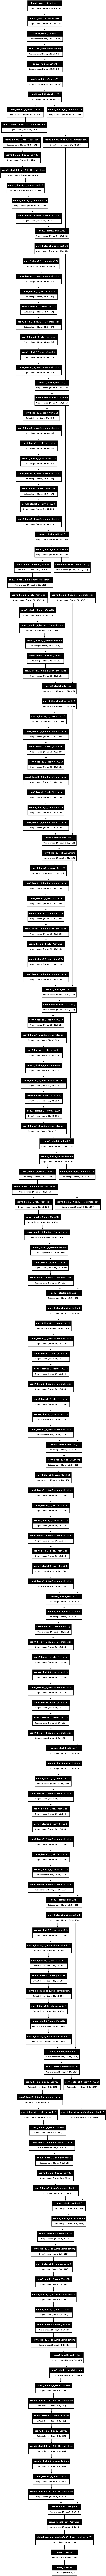

In [60]:
# Plot the model and save it as a PNG file
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, dpi=300, expand_nested=True, rankdir='TB')

In [61]:
optimizer = Nadam(learning_rate= 0.1)
loss_function = CategoricalCrossentropy()

model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=[CategoricalAccuracy()])

In [62]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.00001)

# Define early stopping
#early_stop = EarlyStopping(monitor='categorical_accuracy', patience=5, restore_best_weights=True)

# Train the model using generators with callbacks
history = model.fit(train_generator,
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    epochs=epoch,
                    callbacks=[reduce_lr])

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/900 ━━━━━━━━━━━━━━━━━━━━ 1:45 117ms/step - categorical_accuracy: 0.1406 - loss: 256.6810

W0000 00:00:1715324744.096939      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - categorical_accuracy: 0.1252 - loss: 15.4197

W0000 00:00:1715324844.697992      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


900/900 ━━━━━━━━━━━━━━━━━━━━ 189s 127ms/step - categorical_accuracy: 0.1252 - loss: 15.4075 - val_categorical_accuracy: 0.1252 - val_loss: 2.0997 - learning_rate: 0.1000
Epoch 2/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 98s 108ms/step - categorical_accuracy: 0.1183 - loss: 2.0944 - val_categorical_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.1000
Epoch 3/100


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


900/900 ━━━━━━━━━━━━━━━━━━━━ 111s 123ms/step - categorical_accuracy: 0.1246 - loss: 2.0949 - val_categorical_accuracy: 0.1279 - val_loss: 2.0963 - learning_rate: 0.1000
Epoch 4/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 128s 108ms/step - categorical_accuracy: 0.1224 - loss: 2.0939 - val_categorical_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.1000
Epoch 5/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 111s 123ms/step - categorical_accuracy: 0.1183 - loss: 2.0957 - val_categorical_accuracy: 0.1279 - val_loss: 2.0885 - learning_rate: 0.1000
Epoch 6/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 97s 108ms/step - categorical_accuracy: 0.1172 - loss: 2.0925 - val_categorical_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.1000
Epoch 7/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 111s 123ms/step - categorical_accuracy: 0.1240 - loss: 2.0930 - val_categorical_accuracy: 0.1217 - val_loss: 2.0833 - learning_rate: 0.1000
Epoch 8/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 97s 108ms/step - categorical_accuracy: 0.1220 - los

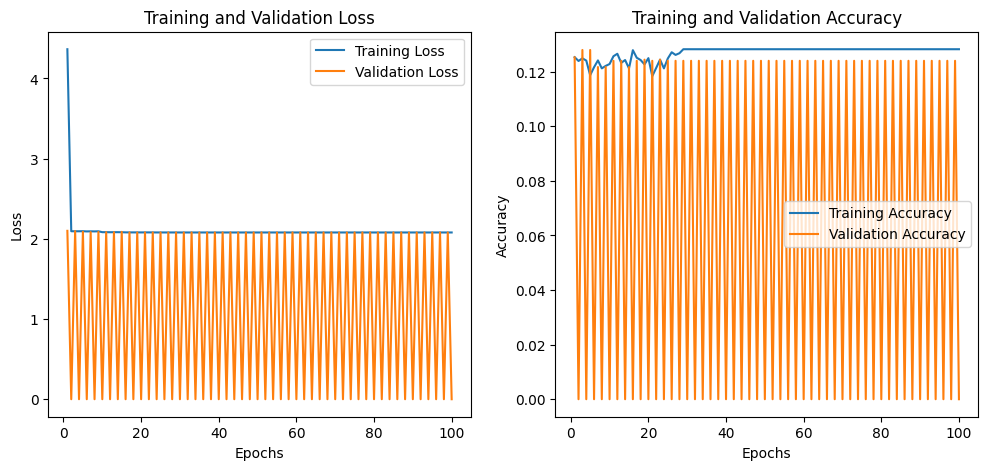

In [63]:
def plot_history(history, dpi=300):
    # Get the training history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['categorical_accuracy']
    val_accuracy = history.history['val_categorical_accuracy']

    # Plot the training history
    epochs_range = range(1, len(loss) + 1)
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, accuracy, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    # Save the plot at the desired DPI
    plt.savefig('training_history_plot.png', dpi=dpi)
    plt.show()

# Plot training history and save at 300 DPI
plot_history(history, dpi=300)

In [64]:
# Save history to a text file
with open('training_history.txt', 'w') as file:
    file.write(str(history.history))

In [65]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

300/300 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - categorical_accuracy: 0.1217 - loss: 2.0801
Test Loss: 2.080075979232788
Test Accuracy: 0.11645833402872086


In [66]:
from tensorflow.keras.models import save_model, load_model

# Define the file path for saving the model
model_path = 'saved_model.h5'

# Save the model to a file
save_model(model, model_path)

# Load the saved model
#loaded_model = load_model(model_path)

# Evaluate the loaded model on the test set
#test_loss, test_accuracy = loaded_model.evaluate(test_generator)
#print("Test Loss:", test_loss)
#print("Test Accuracy:", test_accuracy)